<a href="https://colab.research.google.com/github/CarlosSMWolff/Parameter-Inference/blob/master/2-1-Training_1D_Delta_models-EXPLORATORY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training of Neural Networks

>[Imports](#imports)

>[1D Models](#1D)

>>[Load data](#load)

>>[Model #1: RNN architecture](#RNN)

>>[Model #2: Hist-Dense architecture](#Hist)

# Imports
<a id='imports'></a>

In [1]:
# Find out if this notebook is running in Google Colab
import os
isColab= 'google.colab' in str(get_ipython())
if isColab:
  try:
    device_name = os.environ['COLAB_TPU_ADDR']
    TPU_ADDRESS = 'grpc://' + device_name
    print('Found TPU at: {}'.format(TPU_ADDRESS))
  except KeyError:
    print('TPU not found')

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from random import *
from scipy import stats
from scipy.linalg import expm
from scipy.stats import norm

from tqdm import tqdm

from numpy import exp
from cmath import sqrt

import glob
import pickle
if isColab:
  from google.colab import files
import gc

def plotfill(x,y,var, label, colorfill = "skyblue", colordata = "steelblue", alpha = 0.8, style = 'o'):
    plt.fill_between(x,y-var, y+var,color=colorfill,alpha=alpha,label=label)
    plt.plot(x,y,style,color=colordata,alpha=alpha)

print("Tensorflow has access to the following devices:")
for device in tf.config.list_physical_devices():
  print(f" {device}")

Tensorflow has access to the following devices:
 PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


# 1D Models
<a id='1D'> </a>

## Load data
<a id='load'></a>

### Training data (1D $\Delta$ estimation)

- If this notebook is run online in Google Colab, we download the data from the online repo and the necessary src files.
- Otherwise, we accesss to the local data in `data/training`

In [2]:
if isColab:
  # Load src folder from Dropbox
  ! mkdir src
  ! wget -O src/custom_layers.py https://www.dropbox.com/scl/fi/nzv72gtdwel3pxdvwtan4/custom_layers.py?rlkey=3qvph73s2ltqfu796pzrju0wi&dl=0
  path_tau="taus-Delta-1D-4000000-trajs-24-09-2022.npy"
  path_param = "delta_rand_list-Delta-1D-4000000-trajs-24-09-2022.npy"
  if not os.path.isfile(path_tau):
    ! wget -q --show-progress https://www.dropbox.com/s/so6nlehcq8oexrz/taus-Delta-1D-4000000-trajs-24-09-2022.npy
  if not os.path.isfile(path_param):
    ! wget -q --show progress https://www.dropbox.com/s/3ruxgqsawgh3vcr/delta_rand_list-Delta-1D-4000000-trajs-24-09-2022.npy

else:
  path_tau="data/training/1D-Delta/taus-Delta-1D.npy"
  path_param="data/training/1D-Delta/delta_rand_list-Delta-1D.npy"

In [3]:
tau_list = np.load(path_tau)
Delta_list = np.load(path_param)

ntraj = len(tau_list)

if len(tau_list)!=len(Delta_list):
  print("ERROR: Dimensions of X (tau_list) and Y (Delta_list) do not match!")
else:
  print(f"{ntraj} trajectories loaded")

40000 trajectories loaded


Select the number of trajectories that we want to use for the training

In [4]:
ntraj_select = ntraj
tau_list = tau_list[:ntraj_select].astype(np.float32)
Delta_list = Delta_list[:ntraj_select].astype(np.float32)

- We split the data set: 80% training, 20% validation.

- We do not shuffle the data since the trajectories were already generated randomly

In [12]:
njumps = tau_list.shape[1]

# Set data generated from Monte Carlo
X_train_full, y_train_full = tau_list, Delta_list

lenTrain=int(0.8*len(X_train_full))
X_train, X_valid = X_train_full[:lenTrain], X_train_full[lenTrain:]
y_train, y_valid = y_train_full[:lenTrain], y_train_full[lenTrain:]

## Model #1: RNN architecture
<a id='RNN'></a>

Define and train the network

In [6]:
from src.custom_layers import ExpandDimLayer

def create_model():
  # Set the RNN
  dropout = 0.
  activation = "relu" 
  modelRNN = keras.models.Sequential(
  [ExpandDimLayer(),  # Add custom layer to expand dimensions
    keras.layers.LSTM(17,input_shape=[None,1],return_sequences=True, activation=activation,dropout=dropout),
  keras.layers.LSTM(17, return_sequences=False, activation=activation,dropout=dropout),
  keras.layers.Dense(1)]
  )
  return modelRNN

Training details

In [50]:
epochs = 1000
batch_size = 12800
optimizer = "adam"
loss =  tf.keras.losses.MeanSquaredLogarithmicError()
loss =  tf.keras.losses.MeanAbsoluteError()
loss =  tf.keras.losses.MeanAbsolutePercentageError()
metrics = ["MeanSquaredError"]

Perform training
- If the notebook is run in Colab, it tries to use TPU. 
- Otherwise, train in local machine.

In [51]:
if isColab:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.TPUStrategy(resolver)



  with strategy.scope():
    modelRNN = create_model()
    modelRNN.compile(
        optimizer= optimizer,
        loss=loss,
              metrics=[metrics]
        )

  historyRNN=modelRNN.fit(X_train, y_train,
      epochs=epochs,
      batch_size = batch_size,
      validation_data=(X_valid, y_valid),
      validation_freq=1
)

else:

  print("No colab! Local training")
  modelRNN = create_model()
  modelRNN.compile(
        optimizer= optimizer,
        loss=loss,
              metrics=[metrics]
        )

  historyRNN=modelRNN.fit(X_train, y_train,
      epochs=epochs,
      batch_size = batch_size,
      validation_data=(X_valid, y_valid),
      validation_freq=1)


No colab! Local training
Epoch 1/1000
3/3 [==============================] - 2s 537ms/step - loss: 11522.6494 - mean_squared_error: 769761.4375 - val_loss: 27158.0195 - val_mean_squared_error: 807127.1250
Epoch 2/1000
3/3 [==============================] - 1s 430ms/step - loss: 12729.8037 - mean_squared_error: 908054.9375 - val_loss: 25450.9219 - val_mean_squared_error: 1119113.1250
Epoch 3/1000
3/3 [==============================] - 1s 466ms/step - loss: 14674.1035 - mean_squared_error: 1171427.8750 - val_loss: 23865.3164 - val_mean_squared_error: 1273769.0000
Epoch 4/1000
3/3 [==============================] - 1s 425ms/step - loss: 15375.8252 - mean_squared_error: 1271078.7500 - val_loss: 19594.2188 - val_mean_squared_error: 1244868.3750
Epoch 5/1000
3/3 [==============================] - 1s 479ms/step - loss: 15168.6309 - mean_squared_error: 1278614.0000 - val_loss: 20298.6270 - val_mean_squared_error: 1289456.6250
Epoch 6/1000
1/3 [=========>....................] - ETA: 0s - loss: 

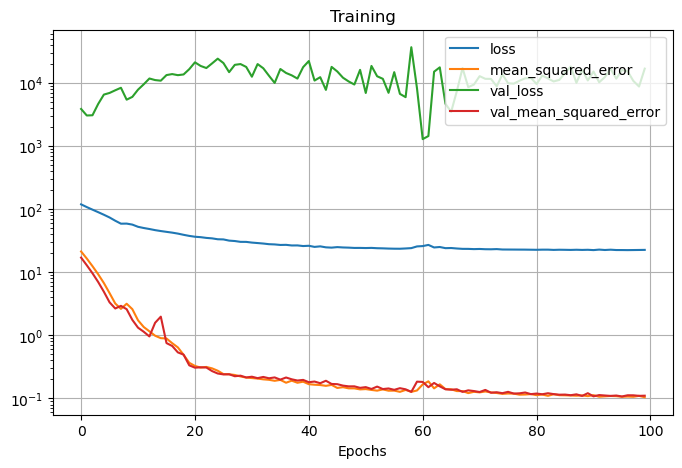

In [48]:
pd.DataFrame(historyRNN.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.title("Training")
plt.grid(True)
plt.yscale("log")
plt.show()

Visualize the predictions made by the model in the validation set

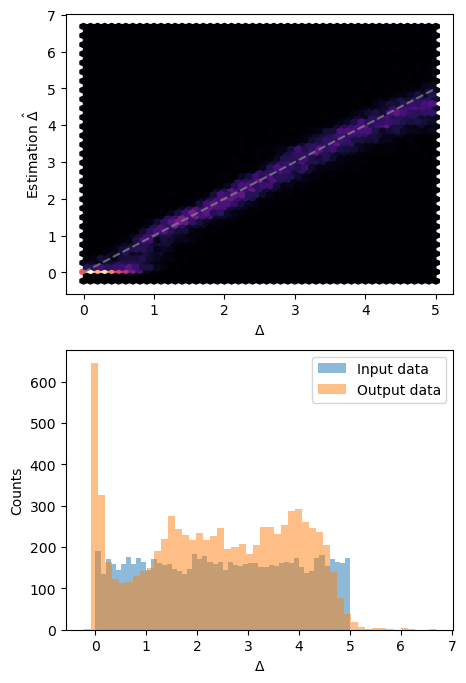

In [49]:
nsel = 10000
x_values = X_valid[np.argsort(y_valid[:nsel])]
output = modelRNN(x_values)[:,0]

input = np.sort(y_valid[:nsel])

fig, axes = plt.subplots(nrows = 2, figsize = (5,8))
ax = axes[0]
ax.hexbin(input,output, gridsize=50, cmap = 'magma')
ax.plot(input,input,'--',color="gray",alpha=0.8)
ax.set_xlabel("$\Delta$"); ax.set_ylabel("Estimation $\hat \Delta$")

ax = axes[1]
ax.hist(input,bins = 50, alpha = 0.5, label = "Input data")
ax.hist(output,bins = 50, alpha = 0.5, label = "Output data")
ax.set_xlabel("$\Delta$"); ax.set_ylabel("Counts")
ax.legend()
plt.show()

Save the model

In [37]:
modelTrainName = f'model-2LSTM-1D-Dense.h5'

if isColab:
    save_path = modelTrainName
else:
    save_path = "data/models/1D/"+modelTrainName

modelRNN.save(save_path)

if isColab:
    from google.colab import files
    files.download(modelTrainName)

## Model #2: Hist-Dense architecture
<a id='Hist'></a>

In [25]:
from src.custom_layers import MyHistogramLayer_Sigmoid

In [ ]:
nbins = 400
taumax = 100
width = taumax/nbins


def create_model():
  # Set the model
  activation = "relu"
  droprate = 0.
  modelHist = keras.models.Sequential(
  [
  MyHistogramLayer_Sigmoid(nbins, taumax, trainable = False),
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
      keras.layers.Dense(1)
   ]
  )
  return modelHist

In [ ]:
  epochs = 50
  optimizer = "adam"
  loss = tf.keras.losses.MeanSquaredLogarithmicError()
  metrics = ["MeanSquaredError"]

In [ ]:
if isColab:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.TPUStrategy(resolver)

  with strategy.scope():
    modelHist = create_model()
    modelHist.compile(
        optimizer= optimizer,
        loss=loss,
              metrics=[metrics]
        )

  history=modelHist.fit(
      X_train, y_train,
      epochs=epochs,
      batch_size = 12800,
      validation_data=(X_valid, y_valid),
      validation_freq=1)

else:
      modelHist = create_model()
      modelHist.compile(
        optimizer= optimizer,
        loss=loss,
              metrics=[metrics]
        )

      history=modelHist.fit(
      X_train, y_train,
      epochs=epochs,
      batch_size = 12800,
      validation_data=(X_valid, y_valid),
      validation_freq=1)


Metal device set to: Apple M2 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

Epoch 1/4


2023-07-12 12:37:00.708634: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


230/250 [==========================>...] - ETA: 2s - loss: 0.0457 - mean_squared_error: 0.3852

KeyboardInterrupt: 

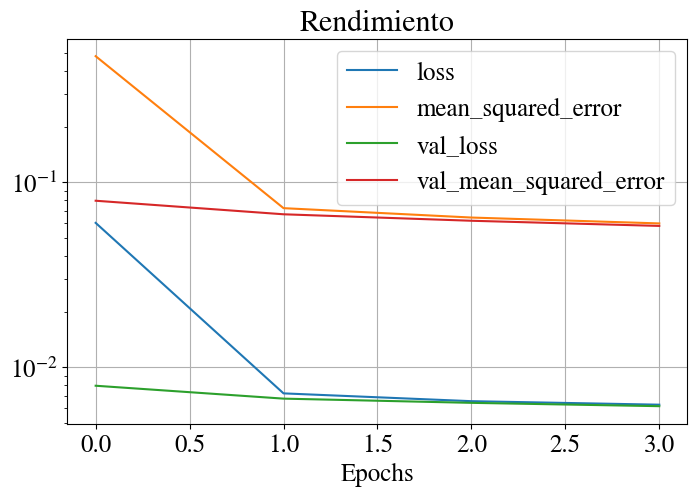

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.title("Rendimiento")
plt.grid(True)
#plt.gca().set_ylim(0, 50) # set the vertical range to [0-1]
plt.yscale("log")
#plt.ylim(0.1,0.2)
plt.show()

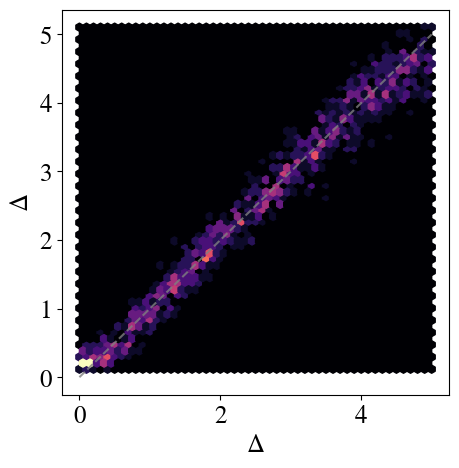

In [ ]:
nsel = 1000
x_values = X_valid[np.argsort(y_valid[:nsel])]
output = modelHist.predict(x_values, verbose=False)[:,0]

input = np.sort(y_valid[:nsel])

fig, axes = plt.subplots(ncols = 1, figsize = (5,5))
ax = axes
ax.hexbin(input,output, gridsize=50, cmap = 'magma')
ax.plot(input,input,'--',color="gray",alpha=0.8)
ax.set_xlabel("$\Delta$"); ax.set_ylabel("$\Delta$")
plt.show()

### Characterize the model

In [ ]:
model = modelHist

In [ ]:
nu=1
nsets=1000
njumps = jumpsSetDelta.shape[2]
gamma = 1
omega = 1.

ndelta = len(deltalist)

jumpsSetDeltaOld = jumpsSetDelta
jumpsSetDeltaList = [jumpsSet[:nsets] for jumpsSet in jumpsSetDelta]

In [ ]:
MSE_NN_delta=[]
MSE_NN_delta_var=[]
DeltaEstimSets_NN_delta = []

def to_time_delay(array):
    return np.concatenate((np.asarray([array[0]]),np.diff(array)))
def to_time_delay_matrix(matrix):
    return np.concatenate((np.reshape(matrix[:,0],(matrix.shape[0],1)),np.diff(matrix)),axis=1)

for i_delta in tqdm(range(ndelta)): #Bucle sobre deltas

    delta=deltalist[i_delta]
    trajectory_matrix = to_time_delay_matrix(jumpsSetDeltaList[i_delta]    )
    Delta_pred= model.predict(trajectory_matrix, verbose= False)

    MSE_NN = np.mean((Delta_pred-delta)**2)
    MSE_NN_var = np.var((Delta_pred-delta)**2)
    MSE_NN_delta.append(MSE_NN)
    MSE_NN_delta_var.append(MSE_NN_var)
    DeltaEstimSets_NN_delta.append(Delta_pred)



MSE_NN_delta = np.asarray(MSE_NN_delta)
MSE_NN_delta_var = np.asarray(MSE_NN_delta_var)
DeltaEstimSets_NN_delta=np.asarray(DeltaEstimSets_NN_delta)

100%|██████████| 40/40 [00:37<00:00,  1.06it/s]


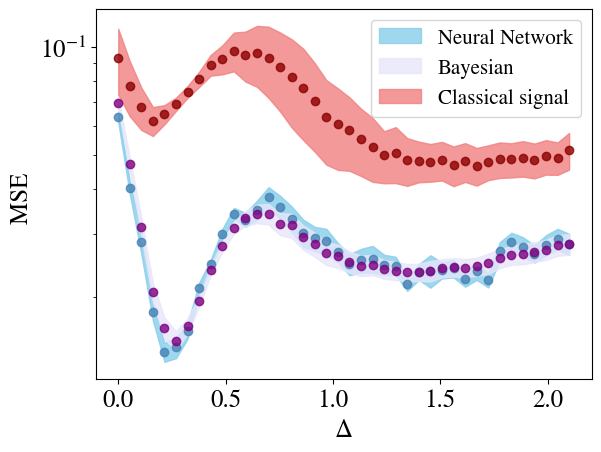

In [ ]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 18})


plotfill(deltalist,MSE_NN_delta,MSE_NN_delta_var, 'Neural Network', colorfill = "skyblue", colordata = "steelblue", alpha = 0.8)
plotfill(deltalist,MSE_Bayes,MSE_Bayes_var, 'Bayesian', colorfill = "lavender", colordata = "purple", alpha = 0.8)
plotfill(deltalist,MSE_Class,MSE_Class_var, 'Classical signal', colorfill = "lightcoral", colordata = "darkred", alpha = 0.8)

plt.xlabel("$\Delta$")
plt.ylabel("MSE ")
plt.yscale('log')
plt.legend(fontsize = 'small')
plt.savefig("figure.png",bbox_inches='tight')
plt.show()


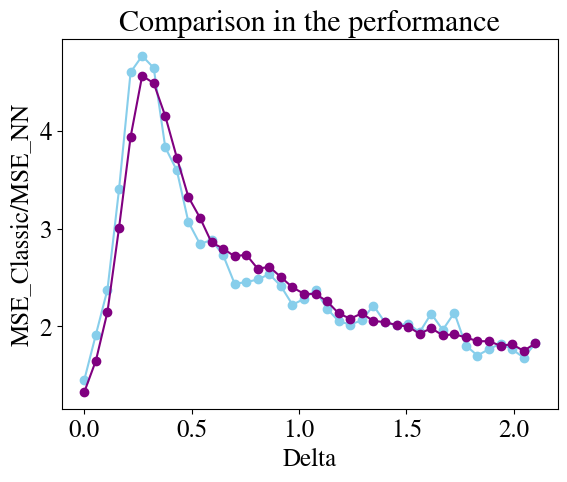

In [ ]:
plt.plot(deltalist,MSE_Class/MSE_NN_delta,'o-',color="skyblue",label="NN")
plt.plot(deltalist,MSE_Class/MSE_Bayes_Mean,'o-',color="purple",label="Bayes-Mean")

plt.xlabel("Delta")
plt.ylabel("MSE_Classic/MSE_NN")
plt.title("Comparison in the performance")
plt.show()

In [ ]:
modelTrainName = f'model-Hist-custom-1D-Dense-ephocs-{epochs}-njumps-{njumps}-ntraj-{ntraj}-activation-relu-Loss_LogMSE.h5'
modelHist.save(modelTrainName)

from google.colab import files
files.download(modelTrainName)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
custom_objects = {"CustomLayer": MyHistogramLayer_Sigmoid, "histogram_sigmoid": histogram_sigmoid}

with keras.saving.custom_object_scope(custom_objects):
    reconstructed_model = keras.models.load_model(modelTrainName, compile=False)

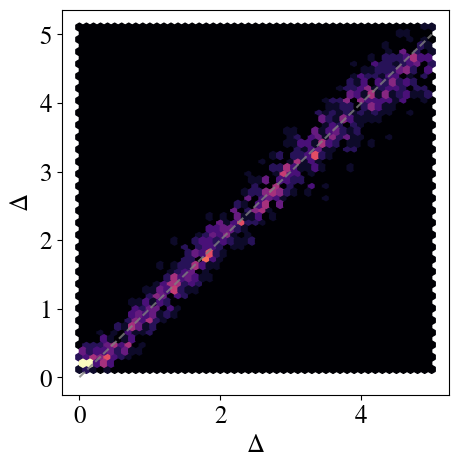

In [ ]:
nsel = 1000
x_values = X_valid[np.argsort(y_valid[:nsel])]
output = reconstructed_model.predict(x_values, verbose=False)[:,0]

input = np.sort(y_valid[:nsel])

fig, axes = plt.subplots(ncols = 1, figsize = (5,5))
ax = axes
ax.hexbin(input,output, gridsize=50, cmap = 'magma')
ax.plot(input,input,'--',color="gray",alpha=0.8)
ax.set_xlabel("$\Delta$"); ax.set_ylabel("$\Delta$")
plt.show()

At small values of $\Delta$, we have some bias problems, both in classical and NN predictions.

---



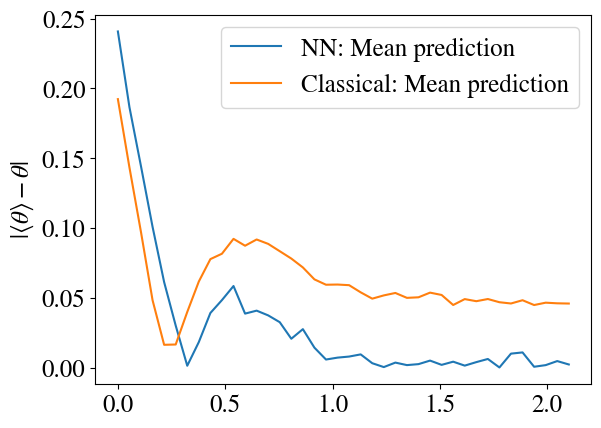

In [ ]:
plt.plot(deltalist,np.abs(deltalist - np.squeeze(np.mean(DeltaEstimSets_NN_delta, axis=1))), label = 'NN: Mean prediction')
plt.plot(deltalist,np.abs(deltalist - np.squeeze(np.mean(DeltaEstimSets_Class_delta, axis=1))), label = 'Classical: Mean prediction')
plt.legend(); plt.ylabel('$|\\langle \\theta \\rangle - \\theta |$')
plt.show()

# Performance VS time (compared to classical) (requires trained modelHist and modelRNN)

In [ ]:
def predictions_trajectory_time(taus_test, model):
  pred_classical_batches = []
  pred_model_batches = []
  pred_classical_total = []
  delta_pred_batch = 0

  for idx in range(nclicks-njumps):
    # Predict for a batch of 48
    taus = taus_test[idx:idx+njumps]
    # Classical prediction
    tfin = np.sum(taus)
    delta_pred_current_batch = delta_pred_TLS(tfin,Omega,gamma,njumps)
    pred_classical_batches.append(delta_pred_current_batch)

    # Predict for all taus so far
    whole_taus = taus_test[0:idx+njumps]
    ntotal = len(whole_taus)
    tfin = np.sum(whole_taus)
    delta_pred_total = delta_pred_TLS(tfin,Omega,gamma,ntotal)
    pred_classical_total.append(delta_pred_total)
  pred_classical_total = np.asarray(pred_classical_total)
  pred_classical_batches = np.asarray(pred_classical_batches)

  taus_batches = np.asarray([taus_test[idx:idx+njumps] for idx in range(nclicks-njumps)])
  if model.input.shape[-1]==1:
    taus_batches = np.expand_dims(taus_batches,axis=-1)
  pred_model_batches = model(taus_batches)

  nbatches_recorded = np.arange(nclicks-njumps)+1

  # Here we consider the average
  pred_classical_cumsum = np.cumsum(pred_classical_batches)/nbatches_recorded
  pred_model_cumsum = np.cumsum(pred_model_batches)/nbatches_recorded

  return pred_classical_cumsum, pred_model_cumsum, pred_classical_batches, pred_model_batches

In [ ]:
delta_test = 0.3
a = destroy(2)
c_ops = [np.sqrt(gamma)*a]
H = delta_test*a.dag()*a + Omega*(a+a.dag())
tfin = 20000; times = [0,tfin]
psi0 = basis(2,0)
ntrajs = 500
result = mcsolve(H,psi0,times,c_ops,ntraj = ntrajs)

min_clicks = np.min(np.asarray([len(result.col_times[i]) for i in range(ntrajs)]))

jumps = np.asarray([result.col_times[i][:min_clicks] for i in range(ntrajs)])

taus_test = to_time_delay_matrix(jumps)
nclicks = min_clicks

10.0%. Run time:  10.75s. Est. time left: 00:00:01:36
20.0%. Run time:  19.95s. Est. time left: 00:00:01:19
30.0%. Run time:  29.49s. Est. time left: 00:00:01:08
40.0%. Run time:  38.25s. Est. time left: 00:00:00:57
50.0%. Run time:  47.46s. Est. time left: 00:00:00:47
60.0%. Run time:  56.46s. Est. time left: 00:00:00:37
70.0%. Run time:  65.58s. Est. time left: 00:00:00:28
80.0%. Run time:  74.57s. Est. time left: 00:00:00:18
90.0%. Run time:  83.74s. Est. time left: 00:00:00:09
100.0%. Run time:  92.30s. Est. time left: 00:00:00:00
Total run time:  92.31s


In [ ]:
nclicks_recorded = np.arange(njumps, nclicks)
time_mean= np.mean(np.cumsum(taus_test,axis=1),axis=0)

In [ ]:
preds_list = [predictions_trajectory_time(taus, modelHist) for taus in tqdm(taus_test)]

100%|██████████| 500/500 [01:26<00:00,  5.80it/s]


In [ ]:
preds_time_classical = np.asarray([preds_list[idx][0] for idx in range(ntrajs)  ])
preds_time_model = np.asarray([preds_list[idx][1] for idx in range(ntrajs)  ])
preds_time_classical_batches = np.asarray([preds_list[idx][2] for idx in range(ntrajs)  ])
preds_time_model_batches = np.squeeze(np.asarray([preds_list[idx][3] for idx in range(ntrajs)  ])) # np.squeeze removes axis of dim=1


preds_time_classical_mean = np.mean(preds_time_classical,axis=0)
preds_time_model_mean = np.mean(preds_time_model,axis=0)

Is there dependence on the initial state for model or classical? If there is, I would expect classical performance to improve (because I assumed steady state), and model performance to suffer (since I always trained with $|\psi_0\rangle = |0\rangle$.

In [ ]:
MSE_model_time = np.mean((preds_time_model_batches-delta_test)**2,axis=0)
MSE_var_model_time = np.var((preds_time_model_batches-delta_test)**2,axis=0)

MSE_Class_time = np.mean((preds_time_classical_batches-delta_test)**2,axis=0)
MSE_var_Class_time = np.var((preds_time_classical_batches-delta_test)**2,axis=0)

We see that the error commited at each batch does not depend on time. The error in the Network is always smaller.

Is it true then that accumulating the signal in the classical case gives to smaller accumulated error? How is that even possible?

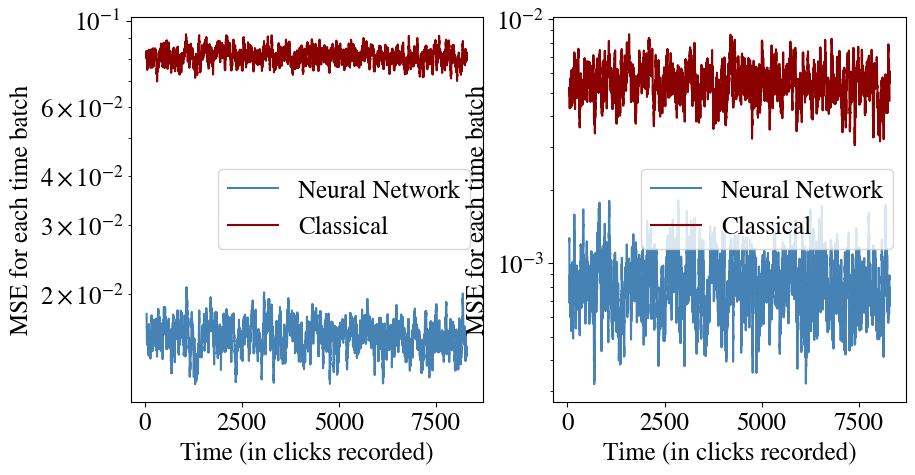

In [ ]:
fig, axes = plt.subplots(ncols = 2, figsize = (10,5))
ax = axes[0]
ax.plot(nclicks_recorded,MSE_model_time, label ='Neural Network', color = "steelblue")
ax.plot(nclicks_recorded,MSE_Class_time, label = 'Classical',color = "darkred")
ax.legend(); ax.set_xlabel("Time (in clicks recorded)"); ax.set_ylabel("MSE for each time batch"); ax.set_yscale('log')

ax = axes[1]
ax.plot(nclicks_recorded,MSE_var_model_time, label ='Neural Network', color = "steelblue")
ax.plot(nclicks_recorded,MSE_var_Class_time, label = 'Classical',color = "darkred")
ax.legend(); ax.set_xlabel("Time (in clicks recorded)"); ax.set_ylabel("MSE for each time batch"); ax.set_yscale('log')

plt.show()


In the following, we can see whether our problem is that our estimator built with the neural network is biased

In [ ]:
nbatches = preds_time_model_batches.shape[-1]

In [ ]:
delta_preds_model_cumsum = np.cumsum(preds_time_model_batches,axis= 1)/ np.tile(np.arange(1,nbatches+1), (ntrajs,1))
delta_preds_class_cumsum = np.cumsum(preds_time_classical_batches,axis= 1)/ np.tile(np.arange(1,nbatches+1), (ntrajs,1))

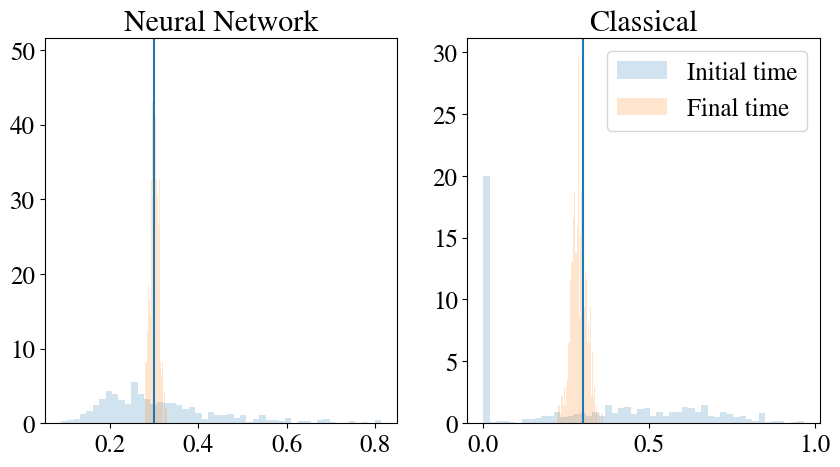

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,5))
ax = axes[0]
ax.hist(delta_preds_model_cumsum[:,0], bins = 50, alpha = 0.2, density = True, label = 'Initial time')
ax.hist(delta_preds_model_cumsum[:,-1], bins = 50, alpha = 0.2, density = True, label = 'Final time')
ax.set_title('Neural Network')
ax.axvline(delta_test)

ax = axes[1]
ax.hist(delta_preds_class_cumsum[:,0], bins = 50, alpha = 0.2, density = True, label = 'Initial time')
ax.hist(delta_preds_class_cumsum[:,-1], bins = 50, alpha = 0.2, density = True, label = 'Final time')
ax.set_title('Classical')
ax.axvline(delta_test)

plt.legend()
plt.show()

In [ ]:
MSE_model_cumsum = (delta_preds_model_cumsum - delta_test)**2
MSE_model_cumsum_mean = np.mean(MSE_model_cumsum, axis=0)

MSE_classical_cumsum = (delta_preds_class_cumsum - delta_test)**2
MSE_classical_cumsum_mean = np.mean(MSE_classical_cumsum, axis=0)

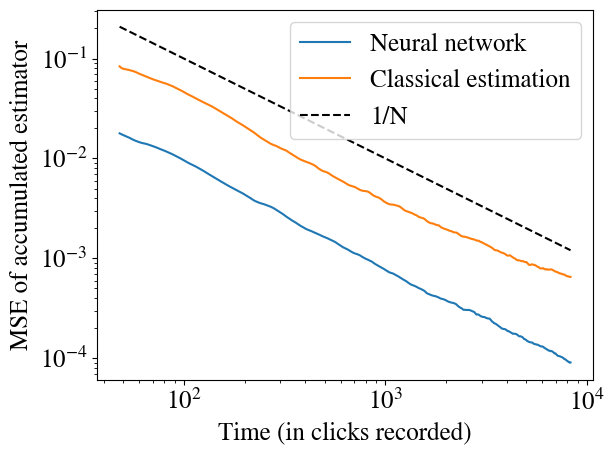

In [ ]:
plt.plot(nclicks_recorded,MSE_model_cumsum_mean, label= 'Neural network' )
plt.plot(nclicks_recorded,MSE_classical_cumsum_mean, label = 'Classical estimation' )
plt.plot(nclicks_recorded,10/nclicks_recorded,'--',color='black', label = '1/N' )

plt.legend(); plt.xlabel("Time (in clicks recorded)"); plt.ylabel("MSE of accumulated estimator"); plt.yscale('log');
plt.xscale('log')

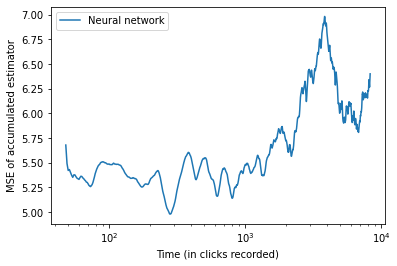

In [ ]:
plt.plot(nclicks_recorded,MSE_classical_cumsum_mean/MSE_model_cumsum_mean, label= 'Neural network' )
plt.legend(); plt.xlabel("Time (in clicks recorded)"); plt.ylabel("MSE of accumulated estimator");
plt.xscale('log')

# Training RNN models with noise in the y_train

Here we add the noise

In [ ]:
def Prepare_data_Noise(tau_list,Delta_list,sigma):
  noise = np.random.normal(loc=0., scale=sigma, size=len(Delta_list))
  Delta_list = np.abs(Delta_list + noise)

  njumps = tau_list.shape[1]
  ntraj = len(tau_list)

  # Set data generated from Monte Carlo
  X_train_full, y_train_full = tau_list, Delta_list

  lenTrain=int(0.8*len(X_train_full))
  X_train, X_valid = X_train_full[:lenTrain], X_train_full[lenTrain:]
  y_train, y_valid = y_train_full[:lenTrain], y_train_full[lenTrain:]
  inputLen = len(X_valid[0])

  X_train_RNN=np.reshape(X_train,(len(X_train),njumps,1))
  X_valid_RNN=np.reshape(X_valid,(len(X_valid),njumps,1))

  return X_train_RNN, y_train, X_valid_RNN, y_valid


### Define and train the network

In [ ]:
def create_model():
  # Set the RNN
  activation = "relu"
  modelRNN = keras.models.Sequential(
  [
   keras.layers.LSTM(17,input_shape=[None,1],return_sequences=True, activation=activation,dropout=0.05),
  keras.layers.LSTM(17, return_sequences=False, activation=activation,dropout=0.05),
      keras.layers.Dense(1)
   ]
  )
  return modelRNN

from keras.callbacks import ModelCheckpoint

def Create_Callback(sigma):
  filepath='my_best_model_2LSTM-sigma_'+str(sigma)+'-.epoch{epoch:02d}-loss{val_loss:.4f}.hdf5'

  checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                              monitor='val_loss',
                              verbose=1,
                              save_best_only=True,
                              mode='min')

  callbacks = [checkpoint]
  return callbacks

In [ ]:
epochs = 15
optimizer = "adam"
loss = "mse"
metrics = ["MeanSquaredError"]

In [ ]:
batch_size = 1280

def train_model_Noise(sigma,epochs=10,verbose=1):

  X_train_RNN, y_train, X_valid_RNN, y_valid =  Prepare_data_Noise(tau_list,Delta_list,sigma)

  if isColab:
    tf.keras.backend.clear_session()

    resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)

    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    print("All devices: ", tf.config.list_logical_devices('TPU'))

    strategy = tf.distribute.TPUStrategy(resolver)



    with strategy.scope():
      modelRNN = create_model()
      modelRNN.compile(
          optimizer= optimizer,
          loss=loss,
                metrics=[metrics]
          )

    historyRNN=modelRNN.fit(
        X_train_RNN.astype(np.float32), y_train.astype(np.float32),
        epochs=epochs,
        batch_size = batch_size,
        validation_data=(X_valid_RNN.astype(np.float32), y_valid.astype(np.float32)),
        validation_freq=1, callbacks=Create_Callback(sigma),
        verbose=verbose
  )

  else:
    # Set the RNN
    modelRNN = create_model()

    activation = "relu"
    modelRNN.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

    historyRNN = modelRNN.fit(X_train_RNN,y_train,epochs=epochs,validation_data = (X_valid_RNN,y_valid),verbose=verbose, batch_size = batch_size)
  return historyRNN, modelRNN


Single example

In [ ]:
sigma = 0.1

In [ ]:
historyRNN, modelRNN= train_model_Noise(sigma=0.,epochs=15,verbose=1)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
Epoch 1/15
248/250 [============================>.] - ETA: 0s - loss: 2339.9968 - mean_squared_error: 2339.9968
Epoch 1: val_loss improved from inf to 58.94118, saving model to my_best_model_2LSTM-sigma_0.0-.epoch01-loss58.9412.hdf5
250/250 [==============================] - 12s 31ms/step - loss: 2321.7141 - mea

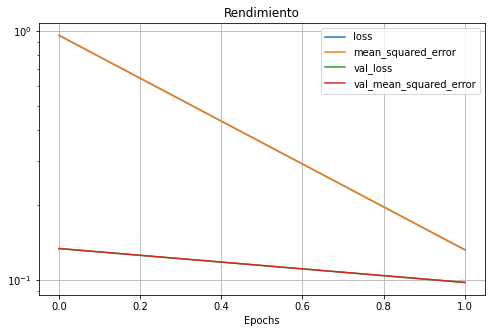

In [ ]:
pd.DataFrame(historyRNN.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.title("Rendimiento")
plt.grid(True)
#plt.gca().set_ylim(0, 50) # set the vertical range to [0-1]
plt.yscale("log")
#plt.ylim(0.1,0.2)
plt.show()

## Loop over different values of sigma

In [ ]:
sigma_min = 0.;sigma_max = 1.;nsigma = 40; sigma_list = np.linspace(sigma_min,sigma_max, nsigma)

In [ ]:
models_sigma_list = [train_model_Noise(sigma,epochs=15,verbose=0) for sigma in tqdm(sigma_list)]

See training performance

In [ ]:
histories = [pd.DataFrame(result[0].history) for result in models_sigma_list]
val_loss_list = np.array([history.val_loss for history in histories])

In [ ]:
np.min(val_loss_list,axis=0)

array([0.11623067, 0.08137755, 0.0745372 , 0.07172428, 0.06759576,
       0.06774502, 0.06951423, 0.06853591, 0.06381591, 0.06157415,
       0.0635424 , 0.06242703, 0.06515308, 0.06697777, 0.06691001])

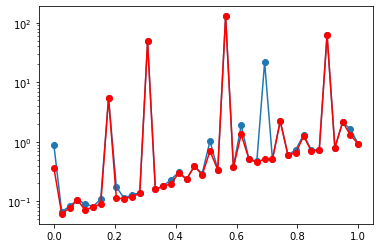

In [ ]:
plt.plot(sigma_list,val_loss_list[:,-1],'-o')
plt.plot(sigma_list,np.min(val_loss_list,axis=1),'-ro')
plt.yscale('log')
plt.show()

I try to fix the worst case

In [ ]:
idx_to_fix = [0,2,5]
models_fix_list = [train_model_Noise(sigma_list[idx],epochs=15,verbose=0) for idx in tqdm(idx_to_fix)]

  0%|          | 0/3 [00:00<?, ?it/s]WARNING:tensorflow:TPU system grpc://10.119.81.98:8470 has already been initialized. Reinitializing the TPU can cause previously created variables on TPU to be lost.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]

Epoch 1: val_loss improved from inf to 0.10063, saving model to my_best_model_2LSTM-sigma_0.0-.epoch01-loss0.1006.hdf5

Epoch 2: val_loss improved from 0.10063 to 0.06494, saving model to my_best_model_2LSTM-sigma_0.0-.epoch02-loss0.0649.hdf5

Epoch 3: val_loss improved from 0.06494 to 0.05816, saving model to 

 33%|███▎      | 1/3 [06:36<13:12, 396.03s/it]WARNING:tensorflow:TPU system grpc://10.119.81.98:8470 has already been initialized. Reinitializing the TPU can cause previously created variables on TPU to be lost.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]

Epoch 1: val_loss improved from inf to 0.08441, saving model to my_best_model_2LSTM-sigma_0.10526315789473684-.epoch01-loss0.0844.hdf5

Epoch 2: val_loss improved from 0.08441 to 0.07122, saving model to my_best_model_2LSTM-sigma_0.10526315789473684-.epoch02-loss0.0712.hdf5

Epoch 3: val_loss improved from 0.07

 67%|██████▋   | 2/3 [13:27<06:44, 404.84s/it]WARNING:tensorflow:TPU system grpc://10.119.81.98:8470 has already been initialized. Reinitializing the TPU can cause previously created variables on TPU to be lost.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]

Epoch 1: val_loss improved from inf to 0.26736, saving model to my_best_model_2LSTM-sigma_0.2631578947368421-.epoch01-loss0.2674.hdf5

Epoch 2: val_loss improved from 0.26736 to 0.14966, saving model to my_best_model_2LSTM-sigma_0.2631578947368421-.epoch02-loss0.1497.hdf5


KeyboardInterrupt: ignored

Try to save only the best

In [ ]:
import glob

for idx in range(20):
  filenamelist = glob.glob(f'*2LSTM-sigma_{sigma_list[idx]}-*')
  epoch_list = np.array([float((name.split('loss')[1]).split('.hdf5')[0]) for name in filenamelist])
  file_best = filenamelist[np.argmin(epoch_list)]
  import shutil
  shutil.copyfile(file_best,f'best-model-sigma_{sigma_list[idx]}.hdf5')

In [ ]:
! mkdir models

In [ ]:
! mv *best-model* models/

In [ ]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/best-model-sigma_0.894736842105263.hdf5 (deflated 48%)
  adding: models/best-model-sigma_0.5263157894736842.hdf5 (deflated 48%)
  adding: models/best-model-sigma_0.3157894736842105.hdf5 (deflated 48%)
  adding: models/best-model-sigma_0.7894736842105263.hdf5 (deflated 48%)
  adding: models/best-model-sigma_0.42105263157894735.hdf5 (deflated 48%)
  adding: models/best-model-sigma_0.0.hdf5 (deflated 48%)
  adding: models/best-model-sigma_0.5789473684210527.hdf5 (deflated 48%)
  adding: models/best-model-sigma_0.10526315789473684.hdf5 (deflated 48%)
  adding: models/best-model-sigma_0.7368421052631579.hdf5 (deflated 48%)
  adding: models/best-model-sigma_0.05263157894736842.hdf5 (deflated 48%)
  adding: models/best-model-sigma_1.0.hdf5 (deflated 48%)
  adding: models/best-model-sigma_0.6842105263157894.hdf5 (deflated 48%)
  adding: models/best-model-sigma_0.9473684210526315.hdf5 (deflated 48%)
  adding: models/best-model-sigma_0.2631578947368

In [ ]:
from google.colab import files
files.download('models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train histogram network (legacy)

## Prepare histogram data

In [ ]:
nbins = 400
taumax= 100

bins = np.linspace(0,taumax,nbins)

print(f"You will generate histograms with {nbins} bins for {int(ntraj_select/1E6)}M trajectories.")

You will generate histograms with 400 bins for 1M trajectories.


In [ ]:
# Verify if histogram with the required nbins and taumax exist
want_to_save = True
# I check if there is any file with the histograms loaded already

filelist = glob.glob(f'*histograms*taumax-{taumax}*nbins-{nbins}-ntrajs-´{ntraj_select}*')
if len(filelist)>0:
  print("File found: unpickling...")
  infile = open(filelist[0],'rb')
  histogram_list_sp = pickle.load(infile)
  histogram_list =tf.sparse.to_dense(histogram_list_sp).numpy()
  infile.close()
  del(histogram_list_sp)
  gc.collect()
else:
  print("File NOT found: creating histogram...")

  histogram_list = np.zeros([len(tau_list), nbins-1])
  for idx, delays in enumerate(tqdm(tau_list)):
    histogram_list[idx] = np.histogram(delays,bins=bins)[0]

  if want_to_save:
    histogram_list_sp = tf.sparse.from_dense(histogram_list)
    filename = f"histograms-sparse-taumax-{taumax}-nbins-{nbins}-ntrajs-´{ntraj_select}"+path_tau.split('taus')[1].split('.npy')[0]+".pkl"
    outfile = open(filename,'wb')
    pickle.dump(histogram_list_sp,outfile)
    outfile.close()
    #files.download(filename)
    del(histogram_list_sp)
    gc.collect()

File found: unpickling...


In [ ]:
X_train_full_Hist, y_train_full_Hist = histogram_list, Delta_list

lenTrain=int(0.8*len(X_train_full))
X_train_Hist, X_valid_Hist = X_train_full_Hist[:lenTrain], X_train_full_Hist[lenTrain:]
y_train_Hist, y_valid_Hist = y_train_full_Hist[:lenTrain], y_train_full_Hist[lenTrain:]
inputLen = len(X_valid_Hist[0])

## Define and train the network using histogram data

In [ ]:
def create_model():
  # Set the model
  activation = "relu"
  droprate = 0
  modelHist = keras.models.Sequential(
  [
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
      keras.layers.Dense(1)
   ]
  )
  return modelHist

In [ ]:
  epochs = 15
  optimizer = "adam"
  #loss = "mse"
  # TO TRY:
  loss = tf.keras.losses.MeanSquaredLogarithmicError()
  metrics = ["MeanSquaredError"]

In [ ]:
if isColab:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.TPUStrategy(resolver)

  with strategy.scope():
    modelHist = create_model()
    modelHist.compile(
        optimizer= optimizer,
        loss=loss,
              metrics=[metrics]
        )

  history=modelHist.fit(
      X_train_Hist.astype(np.float32), y_train_Hist.astype(np.float32),
      epochs=epochs,
      batch_size = 1280,
      # Reduce batch size to avoid training crashing?
      #batch_size = 16,
      validation_data=(X_valid_Hist.astype(np.float32), y_valid_Hist.astype(np.float32)),
      validation_freq=1
)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
Epoch 1/15
625/625 [==============================] - 13s 18ms/step - loss: 0.0214 - mean_squared_error: 0.1918 - val_loss: 0.0071 - val_mean_squared_error: 0.0698
Epoch 2/15
625/625 [==============================] - 7s 12ms/step - loss: 0.0067 - mean_squared_error: 0.0638 - val_loss: 0.0063 - val_mean_squared_

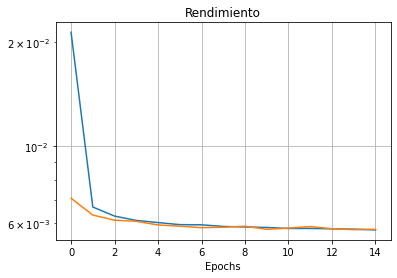

In [ ]:
historyDF=pd.DataFrame(history.history)
plt.plot(historyDF.loss)
plt.plot(historyDF.val_loss)
plt.xlabel("Epochs")
plt.title("Rendimiento")
plt.grid(True)
#plt.gca().set_ylim(0, 50) # set the vertical range to [0-1]
plt.yscale("log")
#plt.ylim(0.1,0.2)
plt.show()

## Validate the model

In [ ]:
model = modelHist

In [ ]:
def to_time_delay(array):
    return np.concatenate((np.asarray([array[0]]),np.diff(array)))

delaysSetDelta = np.array([[to_time_delay(jumps) for jumps in jumpsSet] for jumpsSet in (jumpsSetDelta) ])

In [ ]:
histSetDelta = np.array([[np.histogram(delays,bins=bins)[0] for delays in delaysSet] for delaysSet in tqdm(delaysSetDelta) ])

100%|██████████| 40/40 [00:12<00:00,  3.30it/s]


In [ ]:
nu=1
nsets=10000
njumps = jumpsSetDelta.shape[2]
gamma = 1
omega = 1.

ndelta = len(deltalist)

HistSetDeltaList = [HistSet[:nsets] for HistSet in histSetDelta]
jumpsSetDeltaOld = jumpsSetDelta
jumpsSetDeltaList = [jumpsSet[:nsets] for jumpsSet in jumpsSetDelta]

MSE_NN_delta=[]
MSE_Class_delta=[]
MSE_NN_delta_var=[]
MSE_Class_delta_var=[]
DeltaEstimSets_NN_delta = []
DeltaEstimSets_Class_delta = []

In [ ]:
def to_time_delay_matrix(matrix):
    return np.concatenate((np.reshape(matrix[:,0],(matrix.shape[0],1)),np.diff(matrix)),axis=1)


for i_delta in tqdm(range(ndelta)): #Bucle sobre deltas

    delta=deltalist[i_delta]

    histSet = HistSetDeltaList[i_delta]

    Delta_pred = np.zeros(nu*nsets,float)
    Delta_pred=np.reshape(model.predict(histSet,verbose=0),(nsets))

    MSE_NN = np.mean((Delta_pred-delta)**2)
    MSE_NN_var = np.var((Delta_pred-delta)**2)

    Deltaclassiclist = np.zeros(nsets*nu,float)
    jumpsSet = jumpsSetDeltaList[i_delta]
    tflist=jumpsSet[:,-1]

    for i in range(0,nsets*nu): #Bucle sobre sets
        n_mean=njumps
        tfinal = tflist[i]
        Deltaclassiclist[i]=0.5*np.sqrt(np.abs((4*tfinal*gamma*omega**2-8*n_mean*omega**2-n_mean*gamma**2)/n_mean))

    Delta_predRSClass=np.reshape(Deltaclassiclist,(nsets,nu))
    Delta_pred_sets_classical=np.mean(Delta_predRSClass,1)
    MSE_Class = np.mean((Delta_pred_sets_classical-delta)**2)
    MSE_Class_var = np.var((Delta_pred_sets_classical-delta)**2)


    MSE_NN_delta.append(MSE_NN)
    MSE_NN_delta_var.append(MSE_NN_var)
    MSE_Class_delta.append(MSE_Class)
    MSE_Class_delta_var.append(MSE_Class_var)
    DeltaEstimSets_NN_delta.append(Delta_pred)
    DeltaEstimSets_Class_delta.append(Delta_pred_sets_classical)


MSE_NN_delta = np.asarray(MSE_NN_delta)
MSE_Class_delta = np.asarray(MSE_Class_delta)
DeltaEstimSets_NN_delta=np.asarray(DeltaEstimSets_NN_delta)
DeltaEstimSets_Class_delta = np.asarray(DeltaEstimSets_Class_delta)



100%|██████████| 40/40 [02:10<00:00,  3.26s/it]


Load Bayesian calculation

In [ ]:
path_bayes="estimate_array_delta1D.npy"

if isColab:
  if not os.path.isfile(path_bayes):
    ! wget -q --show-progress https://www.dropbox.com/s/sl9e2ogy43k36pp/estimate_array_delta1D.npy
estimate_array_delta = np.load("estimate_array_delta1D.npy")

MSE_Bayes_Mean = [np.mean((estimate_array_delta[i,:,0]-deltalist[i])**2) for i in range(ndelta)]
MSE_Bayes_Median = [np.mean((estimate_array_delta[i,:,1]-deltalist[i])**2) for i in range(ndelta)]
MSE_Bayes_MLE = [np.mean((estimate_array_delta[i,:,2]-deltalist[i])**2) for i in range(ndelta)]

Plot results

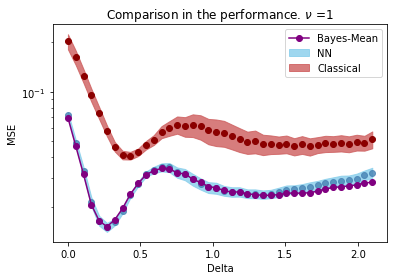

In [ ]:
#plt.plot(preset_deltalist,NN_final,marker="o",label="Neural")
deltalistRed = deltalist

plt.fill_between(deltalistRed,MSE_NN_delta-MSE_NN_delta_var, MSE_NN_delta+MSE_NN_delta_var,color="skyblue",alpha=0.8,label="NN")
plt.plot(deltalistRed,MSE_NN_delta,'o',color="steelblue",alpha=0.8)

plt.fill_between(deltalistRed,MSE_Class_delta-MSE_Class_delta_var, MSE_Class_delta+MSE_Class_delta_var,color="indianred",alpha=0.8,label="Classical")
plt.plot(deltalistRed,MSE_Class_delta,'o',color="darkred")


plt.plot(deltalist,MSE_Bayes_Mean,'o-',color="purple",label="Bayes-Mean")
#plt.plot(deltalist,MSE_Bayes_Median,'o-',color="green",label="Bayes-Median")
#plt.plot(deltalist,MSE_Bayes_MLE,'o-',color="lightseagreen",label="Bayes-MLE")


plt.xlabel("Delta")
plt.ylabel("MSE")
plt.yscale("log")
plt.title("Comparison in the performance. $\\nu$ ="+str(nu))
plt.legend()
plt.show()

Save the model?

In [ ]:
modelTrainName = f'model-Histogram-1D-nbins-{nbins}-ephocs-{epochs}-njumps-{njumps}-ntraj-{ntraj_select}.h5'
modelHist.save(modelTrainName)

from google.colab import files
files.download(modelTrainName)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Training Histogram models with different size of training dataset

In [ ]:
def create_model():
  # Set the model
  activation = "relu"
  droprate = 0.
  modelHist = keras.models.Sequential(
  [
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
      keras.layers.Dense(1)
   ]
  )
  return modelHist

In [ ]:
  optimizer = "adam"
  #loss = "mse"
  # TO TRY:
  loss = tf.keras.losses.MeanSquaredLogarithmicError()
  metrics = ["MeanSquaredError"]

In [ ]:
! rm -r Models_size_training
! mkdir Models_size_training

def Create_Callback(size):
  filepath='Models_size_training/model_best_Hist-size'+str(size)+'.hdf5'

  checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=True,
                              mode='min')

  callbacks = [checkpoint]
  return callbacks

Define datasize interval

In [ ]:
nsizes = 20
size_list = np.asarray([round(x) for x in np.logspace(2,np.log10(len(X_train_Hist)),nsizes)])

Loop over datasizes

In [ ]:
'''from numpy.random import seed
seed(1)
tf.random.set_seed(2)'''

'from numpy.random import seed\nseed(1)\ntf.random.set_seed(2)'

In [ ]:
if isColab:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.TPUStrategy(resolver)

  with strategy.scope():
    modelHist = create_model()
    modelHist.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

  with strategy.scope():
    model_Prev = tf.keras.models.clone_model(modelHist)
    model_Prev.compile(optimizer= optimizer, loss=loss, metrics=[metrics])



 # First do a very quick training (with the smallest size) to initialize the weights for later training
  size = size_list[0]
  X_train_Size = X_train_Hist[:size]
  y_train_Size = y_train[:size]
  model_Prev.fit(X_train_Size.astype(np.float32),y_train_Size.astype(np.float32),epochs=2,
  batch_size = 1280, validation_data=(X_valid_Hist.astype(np.float32), y_valid_Hist.astype(np.float32)), validation_freq=1, verbose = False)


  # Now loop over sigma
  history_list = []

  for size in tqdm(size_list):

    # First we create a model cloning the partially trained one
    with strategy.scope():
      model = tf.keras.models.clone_model(model_Prev)
      model.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

    X_train_Size = X_train_Hist[:size]
    y_train_Size = y_train[:size]

    # Fit the model with noisy data
    #repeats = 6
    #history_sublist = []
    #for idx in range(repeats):
    history = model.fit(X_train_Size.astype(np.float32),
                      y_train_Size.astype(np.float32),
                      epochs=50,
                      callbacks=Create_Callback(size),
                        batch_size = 1280, validation_data=(X_valid_Hist.astype(np.float32), y_valid_Hist.astype(np.float32)), validation_freq=1,
                        verbose = False)
    #  history_sublist.append(history)

#    val_loss = history.val_loss
#    min_loss = np.min(val_loss)

    # Store the history of the training
    history_list.append(history)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


100%|██████████| 20/20 [52:21<00:00, 157.07s/it]


In [ ]:
histories = [pd.DataFrame(result.history) for result in history_list]
val_loss_list = np.array([history.val_loss for history in histories])

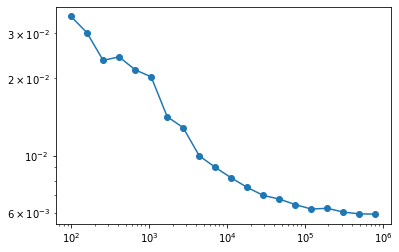

In [ ]:
plt.plot(size_list,val_loss_list[:,-1],'-o')
#plt.plot(size_list,np.min(val_loss_list,axis=1),'-ro')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [ ]:
!zip -r models-size.zip Models_size_training

from google.colab import files
files.download("models-size.zip")

  adding: Models_size_training/ (stored 0%)
  adding: Models_size_training/model_best_Hist-size160.hdf5 (deflated 28%)
  adding: Models_size_training/model_best_Hist-size1708.hdf5 (deflated 14%)
  adding: Models_size_training/model_best_Hist-size2741.hdf5 (deflated 13%)
  adding: Models_size_training/model_best_Hist-size29182.hdf5 (deflated 13%)
  adding: Models_size_training/model_best_Hist-size413.hdf5 (deflated 20%)
  adding: Models_size_training/model_best_Hist-size46831.hdf5 (deflated 13%)
  adding: Models_size_training/model_best_Hist-size120611.hdf5 (deflated 13%)
  adding: Models_size_training/model_best_Hist-size4400.hdf5 (deflated 13%)
  adding: Models_size_training/model_best_Hist-size663.hdf5 (deflated 17%)
  adding: Models_size_training/model_best_Hist-size310626.hdf5 (deflated 13%)
  adding: Models_size_training/model_best_Hist-size11331.hdf5 (deflated 13%)
  adding: Models_size_training/model_best_Hist-size18184.hdf5 (deflated 13%)
  adding: Models_size_training/model_be

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("models-sigma.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Training Histogram models with noise in the y_train

In [ ]:
def create_model():
  # Set the model
  activation = "relu"
  droprate = 0
  modelHist = keras.models.Sequential(
  [
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
      keras.layers.Dense(1)
   ]
  )
  return modelHist

In [ ]:
  epochs = 15
  optimizer = "adam"
  #loss = "mse"
  # TO TRY:
  loss = tf.keras.losses.MeanSquaredLogarithmicError()
  metrics = ["MeanSquaredError"]

In [ ]:
! rm -r Models_sigma
! mkdir Models_sigma

def Create_Callback(sigma):
  filepath='Models_sigma/model_best_Hist-sigma_'+str(sigma)+'.hdf5'

  checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=True,
                              mode='min')

  callbacks = [checkpoint]
  return callbacks

rm: cannot remove 'Models_sigma': No such file or directory


Define $\sigma$ interval

In [ ]:
sigma_min = 0.;sigma_max = 1.;nsigma = 30; sigma_list = np.linspace(sigma_min,sigma_max,nsigma)

Loop over $\sigma$

In [ ]:
if isColab:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.TPUStrategy(resolver)

  with strategy.scope():
    modelHist = create_model()
    modelHist.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

  with strategy.scope():
    model_Prev = tf.keras.models.clone_model(modelHist)
    model_Prev.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

  # First do a very quick training to initialize the weights for later training
  sigma = 0.
  noise = np.random.normal(loc=0., scale=sigma, size=len(y_train_Hist))
  y_train_noise = np.abs(y_train_Hist + noise)

  model_Prev.fit(X_train_Hist.astype(np.float32),
                        y_train_noise.astype(np.float32),
                        epochs=2,
                        callbacks=Create_Callback(sigma),
                         batch_size = 1280, validation_data=(X_valid_Hist.astype(np.float32), y_valid_Hist.astype(np.float32)), validation_freq=1,
                         verbose = False)

  # Now loop over sigma
  history_list = []
  for sigma in tqdm(sigma_list):

      # First we create a model cloning the partially trained one
      with strategy.scope():
        model = tf.keras.models.clone_model(model_Prev)
        model.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

        # Add noise to data
        noise = np.random.normal(loc=0., scale=sigma, size=len(y_train_Hist))
        y_train_noise = np.abs(y_train_Hist + noise)

        # Fit the model with noisy data
        history = model.fit(X_train_Hist.astype(np.float32),
                        y_train_noise.astype(np.float32),
                        epochs=20,
                        callbacks=Create_Callback(sigma),
                         batch_size = 1280, validation_data=(X_valid_Hist.astype(np.float32), y_valid_Hist.astype(np.float32)), validation_freq=1,
                         verbose = False)

        # Store the history of the training
        history_list.append(history)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


100%|██████████| 30/30 [1:08:51<00:00, 137.72s/it]


In [ ]:
histories = [pd.DataFrame(result.history) for result in history_list]
val_loss_list = np.array([history.val_loss for history in histories])

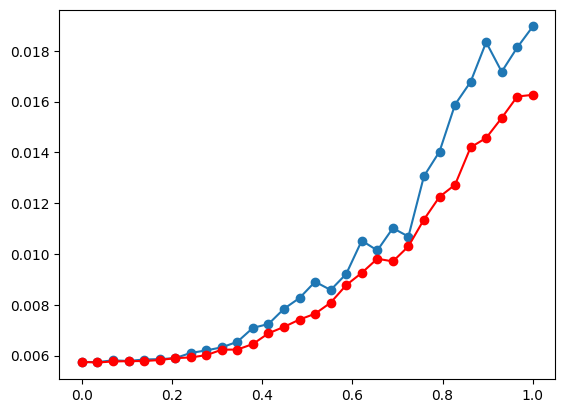

In [ ]:
plt.plot(sigma_list,val_loss_list[:,-1],'-o')
plt.plot(sigma_list,np.min(val_loss_list,axis=1),'-ro')
#plt.yscale('log')
#plt.xscale('log')
plt.show()

In [ ]:
!zip -r models-sigma.zip Models_sigma

from google.colab import files
files.download("models-sigma.zip")

updating: Models_sigma/ (stored 0%)
updating: Models_sigma/model_best_Hist-sigma_0.3103448275862069.hdf5 (deflated 12%)
updating: Models_sigma/model_best_Hist-sigma_0.5517241379310345.hdf5 (deflated 13%)
updating: Models_sigma/model_best_Hist-sigma_0.48275862068965514.hdf5 (deflated 13%)
updating: Models_sigma/model_best_Hist-sigma_0.034482758620689655.hdf5 (deflated 12%)
updating: Models_sigma/model_best_Hist-sigma_0.6551724137931034.hdf5 (deflated 13%)
updating: Models_sigma/model_best_Hist-sigma_0.9655172413793103.hdf5 (deflated 13%)
updating: Models_sigma/model_best_Hist-sigma_0.8620689655172413.hdf5 (deflated 13%)
updating: Models_sigma/model_best_Hist-sigma_0.06896551724137931.hdf5 (deflated 12%)
updating: Models_sigma/model_best_Hist-sigma_0.0.hdf5 (deflated 13%)
updating: Models_sigma/model_best_Hist-sigma_0.20689655172413793.hdf5 (deflated 13%)
updating: Models_sigma/model_best_Hist-sigma_0.3793103448275862.hdf5 (deflated 13%)
updating: Models_sigma/model_best_Hist-sigma_0.241

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("models-sigma.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Training Histogram models with noise in the x_train

In [ ]:
def create_model():
  # Set the model
  activation = "relu"
  droprate = 0
  modelHist = keras.models.Sequential(
  [
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
      keras.layers.Dense(1)
   ]
  )
  return modelHist

In [ ]:
  epochs = 20
  optimizer = "adam"
  #loss = "mse"
  # TO TRY:
  loss = tf.keras.losses.MeanSquaredLogarithmicError()
  metrics = ["MeanSquaredError"]

In [ ]:
! rm -r Models_sigma-x-noise
! mkdir Models_sigma-x-noise

def Create_Callback(sigma):
  filepath='Models_sigma-x-noise/model_best_Hist-sigma_'+str(sigma)+'.hdf5'

  checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=True,
                              mode='min')

  callbacks = [checkpoint]
  return callbacks

Define $\sigma$ interval

In [ ]:
sigma_min = 0.;sigma_max = 1.;nsigma = 30; sigma_list = np.linspace(0,sigma_max,nsigma)

Loop over $\sigma$

In [ ]:
if isColab:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.TPUStrategy(resolver)

  with strategy.scope():
    modelHist = create_model()
    modelHist.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

  with strategy.scope():
    model_Prev = tf.keras.models.clone_model(modelHist)
    model_Prev.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

  # First do a very quick training to initialize the weights for later training
  model_Prev.fit(X_train_Hist.astype(np.float32),
                        y_train_Hist.astype(np.float32),
                        epochs=2,
                        callbacks=Create_Callback(sigma),
                         batch_size = 1280, validation_data=(X_valid_Hist.astype(np.float32), y_valid_Hist.astype(np.float32)), validation_freq=1,
                         verbose = False)

  # Now loop over sigma
  history_list = []
  for sigma in tqdm(sigma_list):

    # First we create a model cloning the partially trained one
    with strategy.scope():
      model = tf.keras.models.clone_model(model_Prev)
      model.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

    # Add noise to x- data (delays)
    noise = np.random.normal(loc=0., scale=sigma, size=tau_list.shape)
    tau_list_noise = (tau_list + noise).clip(min=0)
    histogram_list = np.zeros([len(tau_list_noise), nbins-1])
    for idx, delays in enumerate(tau_list_noise):
      histogram_list[idx] = np.histogram(delays,bins=bins)[0]
    #Proper shape to x-data
    X_train_full_Hist, y_train_full_Hist = histogram_list, Delta_list
    lenTrain=int(0.8*len(X_train_full))
    X_train_Hist, X_valid_Hist = X_train_full_Hist[:lenTrain], X_train_full_Hist[lenTrain:]
    y_train_Hist, y_valid_Hist = y_train_full_Hist[:lenTrain], y_train_full_Hist[lenTrain:]

    # Fit the model with noisy data
    history = model.fit(X_train_Hist.astype(np.float32),
                    y_train.astype(np.float32),
                    epochs=20,
                    callbacks=Create_Callback(sigma),
                      batch_size = 1280, validation_data=(X_valid_Hist.astype(np.float32), y_valid_Hist.astype(np.float32)), validation_freq=1,
                      verbose = False)

      # Store the history of the training
    history_list.append(history)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


100%|██████████| 30/30 [1:22:32<00:00, 165.08s/it]


In [ ]:
histories = [pd.DataFrame(result.history) for result in history_list]
val_loss_list = np.array([history.val_loss for history in histories])

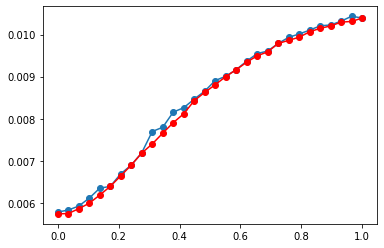

In [ ]:
plt.plot(sigma_list,val_loss_list[:,-1],'-o')
plt.plot(sigma_list,np.min(val_loss_list,axis=1),'-ro')
#plt.yscale('log')
#plt.xscale('log')
plt.show()

In [ ]:
!zip -r models-sigma-x-train.zip Models_sigma-x-noise

from google.colab import files
files.download("models-sigma-x-train.zip")

  adding: Models_sigma-x-noise/ (stored 0%)
  adding: Models_sigma-x-noise/model_best_Hist-sigma_0.1724137931034483.hdf5 (deflated 13%)
  adding: Models_sigma-x-noise/model_best_Hist-sigma_0.3103448275862069.hdf5 (deflated 13%)
  adding: Models_sigma-x-noise/model_best_Hist-sigma_0.9655172413793103.hdf5 (deflated 13%)
  adding: Models_sigma-x-noise/model_best_Hist-sigma_0.6551724137931034.hdf5 (deflated 13%)
  adding: Models_sigma-x-noise/model_best_Hist-sigma_0.20689655172413793.hdf5 (deflated 13%)
  adding: Models_sigma-x-noise/model_best_Hist-sigma_0.034482758620689655.hdf5 (deflated 13%)
  adding: Models_sigma-x-noise/model_best_Hist-sigma_0.24137931034482757.hdf5 (deflated 13%)
  adding: Models_sigma-x-noise/model_best_Hist-sigma_0.3448275862068966.hdf5 (deflated 13%)
  adding: Models_sigma-x-noise/model_best_Hist-sigma_0.0.hdf5 (deflated 13%)
  adding: Models_sigma-x-noise/model_best_Hist-sigma_0.6896551724137931.hdf5 (deflated 13%)
  adding: Models_sigma-x-noise/model_best_Hist-

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Training Histogram models with noise in form of dark counts

In [ ]:
def create_model():
  # Set the model
  activation = "relu"
  droprate = 0
  modelHist = keras.models.Sequential(
  [
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
      keras.layers.Dense(1)
   ]
  )
  return modelHist

In [ ]:
  optimizer = "adam"
  #loss = "mse"
  # TO TRY:
  loss = tf.keras.losses.MeanSquaredLogarithmicError()
  metrics = ["MeanSquaredError"]

In [ ]:
! rm -r Models_sigma-dark-counts-noise
! mkdir Models_sigma-dark-counts-noise

def Create_Callback(sigma):
  filepath='Models_sigma-dark-counts-noise/model_best_Hist-sigma_'+str(sigma)+'.hdf5'

  checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=True,
                              mode='min')

  callbacks = [checkpoint]
  return callbacks

Define $\chi$ interval

In [ ]:
xi_min = 0.;xi_max = 1.;nxi = 30; xi_list = np.linspace(xi_min, xi_max, nxi)

trajectory_matrix_cumsum = np.cumsum(tau_list,axis=1)
tfin_samples = trajectory_matrix_cumsum[:,-1]
nclicks = tau_list.shape[1]

Loop over $\chi$

In [ ]:
if isColab:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.TPUStrategy(resolver)

  with strategy.scope():
    modelHist = create_model()
    modelHist.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

  with strategy.scope():
    model_Prev = tf.keras.models.clone_model(modelHist)
    model_Prev.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

  # First do a very quick training to initialize the weights for later training
  xi=0
  model_Prev.fit(X_train_Hist.astype(np.float32),
                        y_train_Hist.astype(np.float32),
                        epochs=2,
                        callbacks=Create_Callback(xi),
                         batch_size = 1280, validation_data=(X_valid_Hist.astype(np.float32), y_valid_Hist.astype(np.float32)), validation_freq=1,
                         verbose = False)

  # Now loop over sigma
  history_list = []
  for xi in tqdm(xi_list):

    # First we create a model cloning the partially trained one
    with strategy.scope():
      model = tf.keras.models.clone_model(model_Prev)
      model.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

    # Add noise to x- data (delays)
    ndark_trajectories = [np.random.poisson(lam=xi*nclicks) for tfin in  tfin_samples]
    # Get the times of the dark counts
    times_dark = [trajectory_matrix_cumsum[idx,-1]*np.random.random(ndark) for idx, ndark in enumerate(ndark_trajectories)]

    # Create trajectories with added dark counts
    traj_cumsum_darkcounts = np.zeros((len(trajectory_matrix_cumsum),nclicks))
    for idx, trajectory_cumsum in enumerate(trajectory_matrix_cumsum):
        trajectory_wDarkCounts = np.sort(np.concatenate((trajectory_cumsum, times_dark[idx])))[:nclicks]
        traj_cumsum_darkcounts[idx]=trajectory_wDarkCounts
    trajectory_matrix_darkcounts= to_time_delay_matrix(traj_cumsum_darkcounts)

    tau_list_noise = trajectory_matrix_darkcounts

    histogram_list = np.zeros([len(tau_list_noise), nbins-1])
    for idx, delays in enumerate(tau_list_noise):
      histogram_list[idx] = np.histogram(delays,bins=bins)[0]
    #Proper shape to x-data
    X_train_full_Hist, y_train_full_Hist = histogram_list, Delta_list
    lenTrain=int(0.8*len(X_train_full))
    X_train_Hist, X_valid_Hist = X_train_full_Hist[:lenTrain], X_train_full_Hist[lenTrain:]
    y_train_Hist, y_valid_Hist = y_train_full_Hist[:lenTrain], y_train_full_Hist[lenTrain:]

    # Fit the model with noisy data
    history = model.fit(X_train_Hist.astype(np.float32),
                    y_train.astype(np.float32),
                    epochs=20,
                    callbacks=Create_Callback(xi),
                      batch_size = 1280, validation_data=(X_valid_Hist.astype(np.float32), y_valid_Hist.astype(np.float32)), validation_freq=1,
                      verbose = False)

      # Store the history of the training
    history_list.append(history)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


100%|██████████| 30/30 [1:38:13<00:00, 196.45s/it]


In [ ]:
histories = [pd.DataFrame(result.history) for result in history_list]
val_loss_list = np.array([history.val_loss for history in histories])

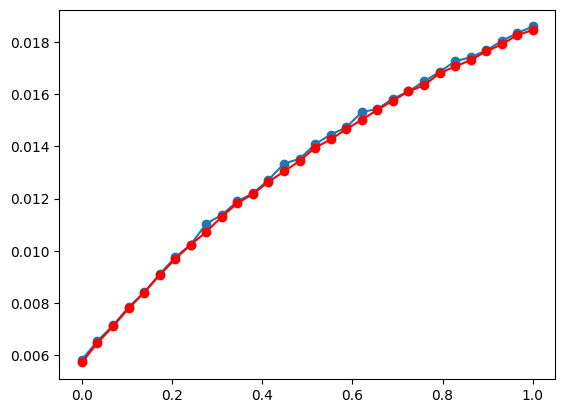

In [ ]:
plt.plot(xi_list,val_loss_list[:,-1],'-o')
plt.plot(xi_list,np.min(val_loss_list,axis=1),'-ro')
#plt.yscale('log')
#plt.xscale('log')
plt.show()

In [ ]:
!zip -r models-sigma-dark-counts-train.zip Models_sigma-dark-counts-noise

from google.colab import files
files.download("models-sigma-dark-counts-train.zip")

  adding: Models_sigma-dark-counts-noise/ (stored 0%)
  adding: Models_sigma-dark-counts-noise/model_best_Hist-sigma_0.3103448275862069.hdf5 (deflated 12%)
  adding: Models_sigma-dark-counts-noise/model_best_Hist-sigma_0.5517241379310345.hdf5 (deflated 12%)
  adding: Models_sigma-dark-counts-noise/model_best_Hist-sigma_0.48275862068965514.hdf5 (deflated 12%)
  adding: Models_sigma-dark-counts-noise/model_best_Hist-sigma_0.034482758620689655.hdf5 (deflated 13%)
  adding: Models_sigma-dark-counts-noise/model_best_Hist-sigma_0.6551724137931034.hdf5 (deflated 12%)
  adding: Models_sigma-dark-counts-noise/model_best_Hist-sigma_0.9655172413793103.hdf5 (deflated 12%)
  adding: Models_sigma-dark-counts-noise/model_best_Hist-sigma_0.8620689655172413.hdf5 (deflated 12%)
  adding: Models_sigma-dark-counts-noise/model_best_Hist-sigma_0.06896551724137931.hdf5 (deflated 13%)
  adding: Models_sigma-dark-counts-noise/model_best_Hist-sigma_0.0.hdf5 (deflated 12%)
  adding: Models_sigma-dark-counts-nois

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train Hist+RNN (parallel)

In [ ]:
from keras import models,layers
from keras.layers import Input,LSTM,Dense
from keras.models import Model

In [ ]:
# This is a parallel model that concatenates both histogram and delay data

def create_model():
  # Set the model
  latent_dim = 20
  dropout = 0.05

  LSTM1_inputA = Input(shape=(None,1))
  NN_inputB = Input(shape=(None))

  Layer1 = LSTM(latent_dim,return_sequences=True,dropout=dropout, activation = 'sigmoid')(LSTM1_inputA)
  Layer2output= LSTM(latent_dim,return_state=False,return_sequences=False,dropout=dropout)(Layer1)
  # We consider the encoded information in the hidden state of the second LSTM
  NN1 = Dense(100)(NN_inputB)
  Concat = layers.concatenate((Layer2output,NN1))
  Output1= Dense(150,activation = 'sigmoid')(Concat)
  Output2= Dense(110)(Output1)
  Output3= Dense(2)(Output2)
  model = Model([LSTM1_inputA ,NN_inputB],Output3)

  return model

In [ ]:
# Custom-made histogram function
nbins = 600
taumax = 100
width = taumax/nbins


def create_model():
  # Set the model
  activation = "relu"
  droprate = 0.
  modelHist = keras.models.Sequential(
  [
  MyHistogramLayer_Sigmoid(nbins, taumax, trainable = True),
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
      keras.layers.Dense(1)
   ]
  )
  return modelHist

In [ ]:
  epochs = 15
  optimizer = "adam"
  loss = tf.keras.losses.MeanSquaredLogarithmicError()
  metrics = ["MeanSquaredError"]

In [ ]:
modelHist = create_model()
modelHist.compile(optimizer= optimizer,loss=loss,metrics=[metrics])

In [ ]:
history=modelHist.fit(
      X_train, y_train,
            epochs=epochs, batch_size = 1280,
            validation_data=(X_valid, y_valid),
      #Increase validation frequency because validation with model.fit() fails?
      validation_freq=30
)

Epoch 1/15
625/625 [==============================] - 6s 7ms/step - loss: 0.0233 - mean_squared_error: 0.2006
Epoch 2/15
625/625 [==============================] - 5s 7ms/step - loss: 0.0064 - mean_squared_error: 0.0606
Epoch 3/15
625/625 [==============================] - 5s 7ms/step - loss: 0.0061 - mean_squared_error: 0.0554
Epoch 4/15
625/625 [==============================] - 5s 7ms/step - loss: 0.0059 - mean_squared_error: 0.0532
Epoch 5/15
625/625 [==============================] - 5s 7ms/step - loss: 0.0058 - mean_squared_error: 0.0522
Epoch 6/15
625/625 [==============================] - 5s 7ms/step - loss: 0.0058 - mean_squared_error: 0.0514
Epoch 7/15
625/625 [==============================] - 5s 7ms/step - loss: 0.0058 - mean_squared_error: 0.0509
Epoch 8/15
625/625 [==============================] - 5s 7ms/step - loss: 0.0057 - mean_squared_error: 0.0506
Epoch 9/15
625/625 [==============================] - 5s 7ms/step - loss: 0.0057 - mean_squared_error: 0.0502
Epoch 10/1

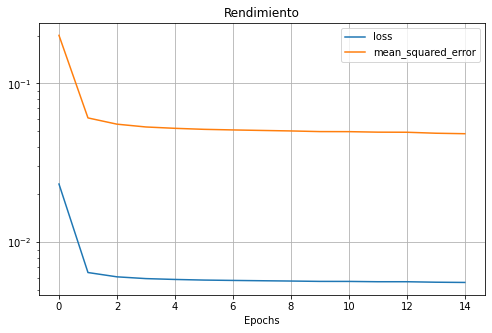

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.title("Rendimiento")
plt.grid(True)
#plt.gca().set_ylim(0, 50) # set the vertical range to [0-1]
plt.yscale("log")
#plt.ylim(0.1,0.2)
plt.show()

### Characterize the model

In [ ]:
model = modelHist

In [ ]:
nu=1
nsets=10000
njumps = jumpsSetDelta.shape[2]
gamma = 1
omega = 1.

ndelta = len(deltalist)

jumpsSetDeltaOld = jumpsSetDelta
jumpsSetDeltaList = [jumpsSet[:nsets] for jumpsSet in jumpsSetDelta]

MSE_NN_delta=[]
MSE_Class_delta=[]
MSE_NN_delta_var=[]
MSE_Class_delta_var=[]
DeltaEstimSets_NN_delta = []
DeltaEstimSets_Class_delta = []

In [ ]:
def to_time_delay(array):
    return np.concatenate((np.asarray([array[0]]),np.diff(array)))
def to_time_delay_matrix(matrix):
    return np.concatenate((np.reshape(matrix[:,0],(matrix.shape[0],1)),np.diff(matrix)),axis=1)


for i_delta in tqdm(range(ndelta)): #Bucle sobre deltas

    delta=deltalist[i_delta]

    jumpsSet = jumpsSetDeltaList[i_delta]
    tflist=jumpsSet[:,-1]

    Delta_pred = np.zeros(nu*nsets,float)
    trajectory_matrix = to_time_delay_matrix(jumpsSet)
    trajectory_matrix = np.reshape(trajectory_matrix, [trajectory_matrix.shape[0],trajectory_matrix.shape[1],1])

    # I had to remove model.predict(), gives error for some reason?
    Delta_pred=model(trajectory_matrix)

    MSE_NN = np.mean((Delta_pred-delta)**2)
    MSE_NN_var = np.var((Delta_pred-delta)**2)


    Deltaclassiclist = np.zeros(nsets*nu,float)


    for i in range(0,nsets*nu): #Bucle sobre sets
        n_mean=njumps
        tfinal = tflist[i]
        Deltaclassiclist[i]=0.5*np.sqrt(np.abs((4*tfinal*gamma*omega**2-8*n_mean*omega**2-n_mean*gamma**2)/n_mean))

    Delta_predRSClass=np.reshape(Deltaclassiclist,(nsets,nu))
    Delta_pred_sets_classical=np.mean(Delta_predRSClass,1)
    MSE_Class = np.mean((Delta_pred_sets_classical-delta)**2)
    MSE_Class_var = np.var((Delta_pred_sets_classical-delta)**2)


    MSE_NN_delta.append(MSE_NN)
    MSE_NN_delta_var.append(MSE_NN_var)
    MSE_Class_delta.append(MSE_Class)
    MSE_Class_delta_var.append(MSE_Class_var)
    DeltaEstimSets_NN_delta.append(Delta_pred)
    DeltaEstimSets_Class_delta.append(Delta_pred_sets_classical)


MSE_NN_delta = np.asarray(MSE_NN_delta)
MSE_Class_delta = np.asarray(MSE_Class_delta)
DeltaEstimSets_NN_delta=np.asarray(DeltaEstimSets_NN_delta)
DeltaEstimSets_Class_delta = np.asarray(DeltaEstimSets_Class_delta)

100%|██████████| 40/40 [00:03<00:00, 13.12it/s]


Load Bayesian calculation

In [ ]:
path_bayes="estimate_array_delta1D.npy"

if isColab:
  if not os.path.isfile(path_bayes):
    ! wget -q --show-progress https://www.dropbox.com/s/sl9e2ogy43k36pp/estimate_array_delta1D.npy
estimate_array_delta = np.load("estimate_array_delta1D.npy")

MSE_Bayes_Mean = [np.mean((estimate_array_delta[i,:,0]-deltalist[i])**2) for i in range(ndelta)]
MSE_Bayes_Median = [np.mean((estimate_array_delta[i,:,1]-deltalist[i])**2) for i in range(ndelta)]
MSE_Bayes_MLE = [np.mean((estimate_array_delta[i,:,2]-deltalist[i])**2) for i in range(ndelta)]

estimate_array_delt 100%[===================>]   9.16M  55.2MB/s    in 0.2s    


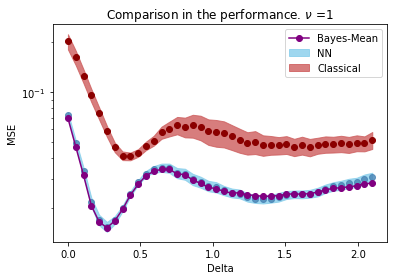

In [ ]:
#plt.plot(preset_deltalist,NN_final,marker="o",label="Neural")
deltalistRed = deltalist

plt.fill_between(deltalistRed,MSE_NN_delta-MSE_NN_delta_var, MSE_NN_delta+MSE_NN_delta_var,color="skyblue",alpha=0.8,label="NN")
plt.plot(deltalistRed,MSE_NN_delta,'o',color="steelblue",alpha=0.8)

plt.fill_between(deltalistRed,MSE_Class_delta-MSE_Class_delta_var, MSE_Class_delta+MSE_Class_delta_var,color="indianred",alpha=0.8,label="Classical")
plt.plot(deltalistRed,MSE_Class_delta,'o',color="darkred")

plt.plot(deltalist,MSE_Bayes_Mean,'o-',color="purple",label="Bayes-Mean")

plt.xlabel("Delta")
plt.ylabel("MSE")
plt.yscale("log")
plt.title("Comparison in the performance. $\\nu$ ="+str(nu))
plt.legend()
plt.show()

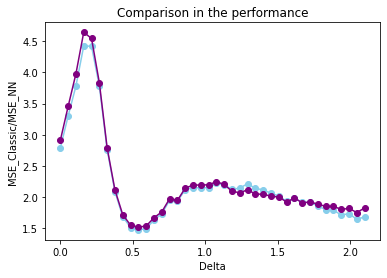

In [ ]:
plt.plot(deltalist,MSE_Class_delta/MSE_NN_delta,'o-',color="skyblue",label="NN")
plt.plot(deltalist,MSE_Class_delta/MSE_Bayes_Mean,'o-',color="purple",label="Bayes-Mean")

plt.xlabel("Delta")
plt.ylabel("MSE_Classic/MSE_NN")
plt.title("Comparison in the performance")
plt.show()

Save the model?

In [ ]:
modelTrainName = f'model-Histogram-Custom-1D-Dense-ephocs-{epochs}-njumps-{njumps}-ntraj-{ntraj}-nbins-{nbins}-taumax-{taumax}.h5'
modelHist.save(modelTrainName)

In [ ]:
from google.colab import files
files.download(modelTrainName)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>